In [76]:
import quandl
import pandas as pd
import numpy as np
import requests
import json
from datetime import date
import os
from datetime import datetime

quandl.ApiConfig.api_key = 'VxZss34XgZXejjDqgZJr'
%matplotlib inline

In [77]:
ticker = 'CAT'
us_exchanges = ['NYSE','NasdaqGS','NasdaqCM','NasdaqGM']
ch_exchanges = ['SHSE', 'SZSE']

company = quandl.get_table('GSCR/GSREF', ticker = ticker)
coy_customers = quandl.get_table('GSCR/GSPLY', supplier_ticker=ticker)
coy_customers.head()

,publish_date,public_domain_date,accounting_as_of_date,supplier_name,supplier_isin,supplier_lei,supplier_exchange,supplier_ticker,customer_name,customer_isin,customer_lei,customer_exchange,customer_ticker,reporting_year,reporting_period,revenue_dependency,revenue_dependency_annotation
None,,,,,,,,,,,,,,,,,
0,2018-05-18,2018-04-17,2017-12-31,Caterpillar Inc.,US1491231015,None,NYSE,CAT,Deleum Berhad,MYL5132OO005,None,KLSE,DELEUM,2017.0,99.0,0.001165,Actual
1,2018-05-18,2017-04-26,2016-12-31,Caterpillar Inc.,US1491231015,None,NYSE,CAT,Deleum Berhad,MYL5132OO005,None,KLSE,DELEUM,2016.0,99.0,0.001718,Actual
2,2018-06-12,2018-04-17,2017-12-31,Caterpillar Inc.,US1491231015,None,NYSE,CAT,Deleum Berhad,MYL5132OO005,None,KLSE,DELEUM,2017.0,99.0,0.001165,Actual
3,2018-06-12,2017-04-26,2016-12-31,Caterpillar Inc.,US1491231015,None,NYSE,CAT,Deleum Berhad,MYL5132OO005,None,KLSE,DELEUM,2016.0,99.0,0.001718,Actual
4,2018-06-12,NaT,NaT,Caterpillar Inc.,US1491231015,None,NYSE,CAT,Victoria Oil & Gas plc,GB00BRWR3752,213800JHNB148AXECS22,AIM,VOG,NaN,NaN,NaN,Non Quantifiable


In [78]:
# Identify customers in the US and China
customer_list = coy_customers[['customer_exchange','customer_ticker']].drop_duplicates()

us_stocks = customer_list[customer_list['customer_exchange'].isin(us_exchanges)]
china_stocks = customer_list[customer_list['customer_exchange'].isin(ch_exchanges)]

In [79]:
# Exchanges
np.unique(customer_list['customer_exchange'])

array(['AIM', 'AMEX', 'ASX', 'ATSE', 'BOVESPA', 'BSE', 'BVC', 'COSE',
       'JKSE', 'JSE', 'KLSE', 'LSE', 'NYSE', 'NasdaqCM', 'NasdaqGS', 'OM',
       'OTCPK', 'PSE', 'Private', 'SEHK', 'SNSE', 'TSX', 'TSXV'],
      dtype=object)

In [80]:
# Download company and customer data
if (os.path.exists("data/{}_prices.csv".format(ticker))):
    price_arr = pd.read_csv("data/{}_prices.csv".format(ticker), index_col = 0)
    price_arr.index = pd.to_datetime(price_arr.index)
else :
    print("Downloading {}...".format(ticker))
    price_arr = curr_download = quandl.get('EOD/{}'.format(ticker))
    price_arr['ticker'] = ticker

    # Download customer data
    for index, row in us_stocks.iterrows():
        print("Downloading {}...".format(row['customer_ticker']))
        try:
            curr_download = quandl.get('EOD/{}'.format(row['customer_ticker']))
            curr_download['ticker'] = row['customer_ticker']
            price_arr = price_arr.append(curr_download)

        except:
            print("Error in downloading {}, {}!".format(row['customer_ticker'], row['customer_exchange']))
    price_arr.columns = [x.lower() for x in price_arr.columns]
    price_arr.to_csv("data/{}_prices.csv".format(ticker))
print("Download complete")

Download complete


In [81]:
# Download China data
if (os.path.exists("data/{}_ch_prices.csv".format(ticker))):
    price_china = pd.read_csv("data/{}_ch_prices.csv".format(ticker), index_col = 0)
    price_china.index = pd.to_datetime(price_china.index)
else :
    price_china = pd.DataFrame()
    for index, row in china_stocks.iterrows():
        try:
            print("Downloading {}...".format(row['customer_ticker']))
            curr_download = quandl.get_table('DY/SPA', ticker = row['customer_ticker'])
            price_china = price_china.append(curr_download)

        except:
            print("Error in downloading {}, {}!".format(row['customer_ticker'], row['customer_exchange']))

    price_china.columns = [x.lower() for x in price_china.columns]
    #price_china = price_china.set_index('date')
    price_china.to_csv("data/{}_ch_prices.csv".format(ticker))
print("Download complete")

Download complete


In [82]:
print(price_arr.columns)
print(price_china.columns)

Index(['open', 'high', 'low', 'close', 'volume', 'dividend', 'split',
       'adj_open', 'adj_high', 'adj_low', 'adj_close', 'adj_volume', 'ticker'],
      dtype='object')
Index([], dtype='object')


In [83]:
# Combine US and China
price_arr = price_arr[['ticker', 'adj_open', 'adj_high','adj_low','adj_close','adj_volume']]
if len(price_china) > 0:
    price_china = price_china[['ticker', 'adj_open', 'adj_high','adj_low','adj_close','turnover_volume']]

    price_china.columns = ['ticker', 'adj_open', 'adj_high','adj_low','adj_close','adj_volume']
    price_arr = price_arr.append(price_china)
price_arr.tail()

,ticker,adj_open,adj_high,adj_low,adj_close,adj_volume
Date,,,,,,
2019-03-20,CLD,0.1900,0.2378,0.1780,0.2070,14669095.0
2019-03-21,CLD,0.2055,0.2100,0.1900,0.1926,4908698.0
2019-03-22,CLD,0.1980,0.2040,0.1810,0.1865,4129543.0
2019-03-25,CLD,0.1800,0.1870,0.1620,0.1650,5702845.0
2019-03-26,CLD,0.1620,0.1730,0.1505,0.1565,1846394.0


In [84]:
# Calculate returns
price_arr.index = pd.to_datetime(price_arr.index)
price_arr = price_arr['2015-01-01':'2019-09-30']
price_wide = price_arr[['ticker','adj_close']].pivot(columns = 'ticker')
returns_arr = price_wide / price_wide.shift(1) - 1
returns_arr = returns_arr.fillna(0)[2:]  #Fill holidays with 0, remove first 2 rows

returns_arr.columns = returns_arr.columns.droplevel()

In [85]:
# Download sentiment
fbup = quandl.get_table('SMA/FBUP', created_time = {'gte': '2015-01-01'}, brand_ticker=ticker)
fbup['date'] = pd.to_datetime(fbup['created_time']).dt.date
fbup = fbup.replace({'sentiment' : { 'NEGATIVE' : -1, 'POSITIVE' : 1, 'NEUTRAL' : 0, 'UNDEFINED':0 }})

fbup['positive_sentiment'] = np.where(fbup['sentiment'] > 0, 1, 0)
fbup['negative_sentiment'] = np.where(fbup['sentiment'] < 0, 1, 0)
fbup['scaled_pos'] = fbup['positive_sentiment'] * np.log(fbup['likes'] + fbup['shares'] + 1)
fbup['scaled_neg'] = fbup['negative_sentiment'] * np.log(fbup['likes'] + fbup['shares'] + 1)

fb_sentiment = fbup.groupby('date')[['positive_sentiment','negative_sentiment', 'scaled_pos', 'scaled_neg']].sum()
#fb_sentiment = fbup.groupby('date')[['positive_sentiment','negative_sentiment']].sum()
fb_sentiment = fb_sentiment.fillna(0)
fb_sentiment['scaled_sum'] = fb_sentiment['scaled_pos'] - fb_sentiment['scaled_neg']

returns_arr = returns_arr.join(fb_sentiment)
returns_arr = returns_arr.fillna(0)

In [86]:
def add_lags(returns_arr, lags):
    all_ret = returns_arr
    
    for lag in range(1, lags + 1):
        returns_lagged = returns_arr.shift(lag)
        returns_lagged.columns = [str(x) + "_lag{}".format(lag) for x in returns_lagged.columns.to_list()]
        
        all_ret = pd.concat([all_ret, returns_lagged], axis=1)
    
    return all_ret[lags:]

In [87]:
returns_arr = add_lags(returns_arr, 10)

In [88]:
target_stock = returns_arr[ticker]
cust_stock = returns_arr[[x for x in returns_arr.columns if x != ticker]]

cust_stock = cust_stock.shift(1)[1:] # Lag 1 for prediction

In [89]:
X = cust_stock
y = target_stock[1:]
X.shape, y.shape

((1181, 329), (1181,))

In [90]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import RidgeClassifierCV
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.neural_network import MLPClassifier
import xgboost as xgb
from xgboost import XGBClassifier
from mlxtend.classifier import StackingCVClassifier
from sklearn.metrics import confusion_matrix
from sklearn.utils import class_weight

# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

In [91]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.10, shuffle = False)
#X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.15, shuffle = False)
X_train.shape, X_test.shape

((1062, 329), (119, 329))

In [92]:
std = y_train.std()
y_train_ret = y_train
y_train = pd.cut(y_train, [-500*std,-1*std, -0.5*std, 0.5*std, 1*std,500*std], labels=[-2,-1,0,1,2]) 
#y_val = pd.cut(y_val, [-500*std,-1*std, -0.5*std, 0.5*std, 1*std,500*std], labels=[-2,-1,0,1,2]) 
y_test_ret = y_test
y_test = pd.cut(y_test, [-500*std,-1*std, -0.5*std, 0.5*std, 1*std,500*std], labels=[-2,-1,0,1,2]) 

In [93]:
alphas_alt = [0.01, 0.05, 0.1, 1, 5, 10]
alphas2 = [5e-05, 0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008]
e_alphas = [0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007]
e_l1ratio = [0.8, 0.85, 0.9, 0.95, 0.99, 1]

In [94]:
cw = class_weight.compute_class_weight('balanced', np.unique(y_train), y_train)
cw = {-2:cw[0], -1:cw[1], 0:cw[2], 1:cw[3], 2:cw[4]}

In [95]:
tscv = TimeSeriesSplit(n_splits=5)

ridge = make_pipeline(RobustScaler(),
                     RidgeClassifierCV(alphas = alphas_alt, cv = tscv, class_weight = cw))

rfc = make_pipeline(RobustScaler(),
                     RandomForestClassifier(n_estimators=50, max_depth=4,random_state=0, class_weight = cw))

svc = make_pipeline(RobustScaler(),
                    SVC(gamma='auto', class_weight = cw))

svc_linear = make_pipeline(RobustScaler(),
                           SVC(kernel="linear", C=0.025, class_weight = cw))

nn = make_pipeline(RobustScaler(),
                  MLPClassifier(alpha=10, max_iter=1000),)

xgboost = make_pipeline(RobustScaler(),
                  XGBClassifier(learning_rate=0.01, n_estimators=50,
                                max_depth=3, min_child_weight=0,
                                gamma=10))   

ada = make_pipeline(RobustScaler(),
                   AdaBoostClassifier(n_estimators = 200, learning_rate = 0.05))


In [96]:
rfc.fit(np.array(X_train), np.array(y_train))


Pipeline(memory=None,
         steps=[('robustscaler',
                 RobustScaler(copy=True, quantile_range=(25.0, 75.0),
                              with_centering=True, with_scaling=True)),
                ('randomforestclassifier',
                 RandomForestClassifier(bootstrap=True,
                                        class_weight={-2: 1.7129032258064516,
                                                      -1: 1.6992,
                                                      0: 0.40767754318618044,
                                                      1: 1.495774647887324,
                                                      2: 1.416},
                                        criterion='gini', max_depth=4,
                                        max_features='auto',
                                        max_leaf_nodes=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                

In [97]:
stack_gen = StackingCVClassifier(classifiers=(ridge, rfc, svc, svc_linear, nn, xgboost, ada),
                               meta_classifier=xgboost,
                               use_features_in_secondary=True)

In [98]:
%%time
# Fit data
stack_gen.fit(np.array(X_train), np.array(y_train))
print(stack_gen.score(X_train,y_train), stack_gen.score(X_test, y_test))

0.4915254237288136 0.4369747899159664
CPU times: user 50.2 s, sys: 2.75 ms, total: 50.2 s
Wall time: 50.2 s


In [99]:
%%time
print('START Fit')
print(datetime.now(), 'Ridge')
ridge_model = ridge.fit(np.array(X_train), np.array(y_train))
print(datetime.now(), 'RandomForest')
rfc_model = rfc.fit(X_train, y_train)
print(datetime.now(), 'SVC')
svc_model = svc.fit(X_train, y_train)
print(datetime.now(), 'SVC (linear)')
svc_linear_model = svc_linear.fit(X_train, y_train)
#print(datetime.now(), 'Gaussian Probability')
#gpc_model = gpc.fit(X_train, y_train)
print(datetime.now(), 'Neural Network')
nn_model = nn.fit(X_train, y_train)
#print(datetime.now(), 'xgboost')
#xgb_model = xgboost.fit(X_train, y_train, xgbclassifier__sample_weight = cw)
#print(datetime.now(), 'AdaBoost')
#ada_model = ada.fit(X_train, y_train, adaboostclassifier__sample_weight = cw)

START Fit
2019-10-20 08:16:50.927144 Ridge
2019-10-20 08:16:51.265199 RandomForest
2019-10-20 08:16:51.574072 SVC
2019-10-20 08:16:52.603521 SVC (linear)
2019-10-20 08:16:58.596551 Neural Network
CPU times: user 11 s, sys: 0 ns, total: 11 s
Wall time: 11 s


In [74]:
print(ridge_model.predict(X_train).mean(),
      rfc_model.predict(X_train).mean(),
      svc_model.predict(X_train).mean(),
      svc_linear_model.predict(X_train).mean(),
      #gpc_model.predict(X_train).mean(),
      nn_model.predict(X_train).mean())
      #xgb_model.predict(X_train).mean(),
      #ada_model.predict(X_train).mean())
      
      

0.007532956685499058 0.031073446327683617 0.06497175141242938 0.011299435028248588 0.0743879472693032


In [100]:
returns = pd.DataFrame({
    'stock': y_test_ret,
    'ridge': ridge_model.predict(X_test) * y_test_ret * 0.5,
    'rfc': rfc_model.predict(X_test) * y_test_ret * 0.5,
    'svc': svc_linear_model.predict(X_test) * y_test_ret * 0.5,
    'nn': nn_model.predict(X_test) * y_test_ret * 0.5
})

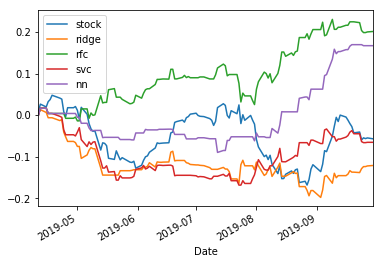

In [101]:
returns.cumsum().plot()

In [102]:
confusion_matrix(ridge_model.predict(X_test), y_test)

array([[ 2,  2,  5,  3,  4],
       [ 3,  3,  9,  2,  4],
       [ 3,  6, 15,  6,  2],
       [ 1,  0,  8,  5,  3],
       [ 6,  6, 15,  2,  4]])

In [103]:
y_test.value_counts()

 0    52
 1    18
 2    17
-1    17
-2    15
Name: CAT, dtype: int64

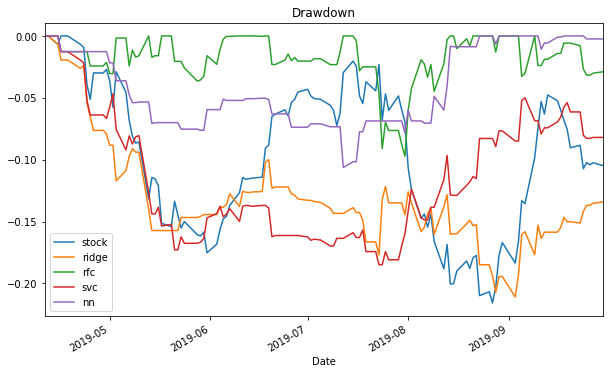

In [104]:
def drawdown(returns):
    return returns.cumsum() - returns.cumsum().cummax()

drawdown(returns).plot(figsize = (10, 6), title = "Drawdown")

In [105]:
def blend_models_predict(X):
    return ((0.1 * elastic_model_full_data.predict(X)) +
           0.1 * lasso_model_full_data.predict(X) + 
           0.1 * ridge_model_full_data.predict(X) + 
           0.1 * svr_model_full_data.predict(X) + 
           0.1 * gbr_model_full_data.predict(X) + 
           0.15 * xgb_model_full_data.predict(X) + 
           0.1 * lgb_model_full_data.predict(X) + 
           0.25 * stack_gen_model.predict(np.array(X)))

print("RMSLE score on train data")
print(rmsle(y, blend_models_predict(X)))

RMSLE score on train data


NameError: name 'rmsle' is not defined

# Generate timeseries for customers 

In [263]:
coy_customers[coy_customers['customer_ticker'] == "AMX"].head()

,publish_date,public_domain_date,accounting_as_of_date,supplier_name,supplier_isin,supplier_lei,supplier_exchange,supplier_ticker,customer_name,customer_isin,customer_lei,customer_exchange,customer_ticker,reporting_year,reporting_period,revenue_dependency,revenue_dependency_annotation
None,,,,,,,,,,,,,,,,,
88,2018-05-18,NaT,NaT,Apple Inc.,US0378331005,HWUPKR0MPOU8FGXBT394,NasdaqGS,AAPL,America Movil S.A.B. de C.V.,MXP001691213,5493000FNR3UCEAONM59,NYSE,AMX,NaN,NaN,NaN,Non Quantifiable
265,2018-06-12,NaT,NaT,Apple Inc.,US0378331005,HWUPKR0MPOU8FGXBT394,NasdaqGS,AAPL,America Movil S.A.B. de C.V.,MXP001691213,5493000FNR3UCEAONM59,NYSE,AMX,NaN,NaN,NaN,Non Quantifiable
442,2018-07-09,NaT,NaT,Apple Inc.,US0378331005,HWUPKR0MPOU8FGXBT394,NasdaqGS,AAPL,America Movil S.A.B. de C.V.,MXP001691213,5493000FNR3UCEAONM59,NYSE,AMX,NaN,NaN,NaN,Non Quantifiable
619,2018-08-08,NaT,NaT,Apple Inc.,US0378331005,HWUPKR0MPOU8FGXBT394,NasdaqGS,AAPL,America Movil S.A.B. de C.V.,MXP001691213,5493000FNR3UCEAONM59,NYSE,AMX,NaN,NaN,NaN,Non Quantifiable
796,2018-05-18,NaT,NaT,Apple Inc.,US0378331005,HWUPKR0MPOU8FGXBT394,NasdaqGS,AAPL,America Movil S.A.B. de C.V.,MXP001691213,5493000FNR3UCEAONM59,NYSE,AMX,NaN,NaN,NaN,Non Quantifiable


In [261]:
coy_customers[coy_customers['customer_exchange'].isin(us_exchanges)].groupby(['customer_ticker'])['public_domain_date'].min()

customer_ticker
AMX           NaT
BBY    2010-04-28
CDW           NaT
CHL    2014-04-08
CNV           NaT
CNXN          NaT
DCM    2010-06-24
DFS           NaT
DPZ           NaT
EEFT          NaT
GRPN          NaT
HAS           NaT
HAWK          NaT
HBAN          NaT
HGG           NaT
IBM           NaT
IM     2013-05-07
LKM           NaT
LXK           NaT
MEET          NaT
MOBL          NaT
NETE          NaT
NEWR          NaT
NIHD          NaT
NSIT          NaT
NTRS          NaT
NXTM          NaT
PCMI          NaT
PHG           NaT
PLUS          NaT
PNRA          NaT
RCII          NaT
S      2014-05-27
T      2014-02-21
TDOC          NaT
TECD   2012-03-21
TMUS   2014-02-25
TTWO          NaT
TWTR          NaT
USM           NaT
VZ     2006-03-14
XRX           NaT
Name: public_domain_date, dtype: datetime64[ns]

# Get refinitive price

In [33]:
# Global functions - make HTTP GET reqeust
def get_data_request(url, requestData):
    dResp = requests.get(url, headers = {'X-api-key': access_token}, params = requestData);       

    
    if dResp.status_code != 200:
        print("Unable to get data. Code %s, Message: %s" % (dResp.status_code, dResp.text));
    else:
        print("Data access successful")
        jResp = json.loads(dResp.text);
        return jResp

In [56]:
ric = 'AAPL.O' # APPLE
start_date = '2016-11-01'
end_date = '2019-06-30'

RESOURCE_ENDPOINT = "https://dsa-stg-edp-api.fr-nonprod.aws.thomsonreuters.com/data/historical-pricing/beta1/views/summaries/" + ric
access_token = 'KihQNsQ4zK9hitOqy1AoN4F2GJA8Hhwh4JMXn8bL'  # your personal key for Data Science Accelerator access to Pricing Data
requestData = {
    "interval": "P1D",
    "start": start_date,
    "end": end_date,
    "fields": 'TRDPRC_1,BID,ASK,OPEN_PRC,HIGH_1,LOW_1,TRDPRC_1,NUM_MOVES,TRNOVR_UNS'
};

jResp = get_data_request(RESOURCE_ENDPOINT, requestData)


if jResp is not None:
    data = jResp[0]['data']
    headers = jResp[0]['headers']  
    names = [headers[x]['name'] for x in range(len(headers))]
    close_price = pd.DataFrame(data, columns=names )
    
close_price.columns = ['DATE', 'CLOSE', 'BID']
close_price.set_index(pd.to_datetime(close_price.DATE), inplace=True) # set the index to be the DATE
close_price.sort_index(inplace=True)  # sort the dataframe by the newly created datetime index

close_price.head()

Unable to get data. Code 400, Message: Field: end must be on or before 2019-06-30


,DATE,CLOSE,BID
DATE,,,
2016-11-01,2016-11-01,111.49,111.48
2016-11-02,2016-11-02,111.59,111.60
2016-11-03,2016-11-03,109.83,109.82
2016-11-04,2016-11-04,108.84,108.84
2016-11-07,2016-11-07,110.41,110.40
